In [156]:
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv('../data/21-25.csv')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np 

# Define features
features_no_scaling = ["priceEarningsRatio", "priceToSalesRatio", "enterpriseValueMultiple"]
features_to_scale = ["priceToFreeCashFlowsRatio"]

# Work on a copy to avoid modifying original data
df_scaled = df.copy()

# Drop rows with NaNs in the feature to be scaled
df_scaled = df_scaled.dropna(subset=features_to_scale)

# Apply StandardScaler ONLY to the selected feature
scaler = StandardScaler()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

# Create final DataFrame with both scaled and unscaled features
df_final = df_scaled[features_no_scaling].join(df_scaled[features_to_scale])

# Check results
print(df_final.describe())
df_final = df_final.dropna()
df_final = df_final.select_dtypes(include=[np.number])

       priceEarningsRatio  priceToSalesRatio  enterpriseValueMultiple  \
count        7.848000e+03        7848.000000             7.848000e+03   
mean         6.082658e+03          17.997463             7.611896e+02   
std          5.388406e+05          47.739829             7.582869e+04   
min         -2.599613e+05         -31.170533            -1.039759e+06   
25%          1.216393e+01           6.037634             3.740557e+01   
50%          2.122628e+01          11.551364             5.722840e+01   
75%          3.367837e+01          21.638653             8.281984e+01   
max          4.773442e+07        2931.421088             6.633582e+06   

       priceToFreeCashFlowsRatio  
count               7.848000e+03  
mean               -3.621523e-18  
std                 1.000064e+00  
min                -7.471246e+01  
25%                -1.580654e-02  
50%                 3.281243e-03  
75%                 2.784729e-02  
max                 2.639311e+01  
priceEarningsRatio         

In [160]:
# Elbow method and silhoutte method to find ideal number of clusters 
inertia = [] # elbow 
silhouette_scores = [] # silhouette
K_range = range(2, 15)  # Trying k from 2 to 14

for k in K_range:
    # run for each k, random intialization, runs 10 times and picks the best minimum 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_final)
    
    # inertia is the sum of squared distances of samples to their closest cluster center (elboq)
    inertia.append(kmeans.inertia_)
    # silhouette score is the mean silhouette coefficient of all samples (silhouette)
    silhouette_scores.append(silhouette_score(df_final, kmeans.labels_))

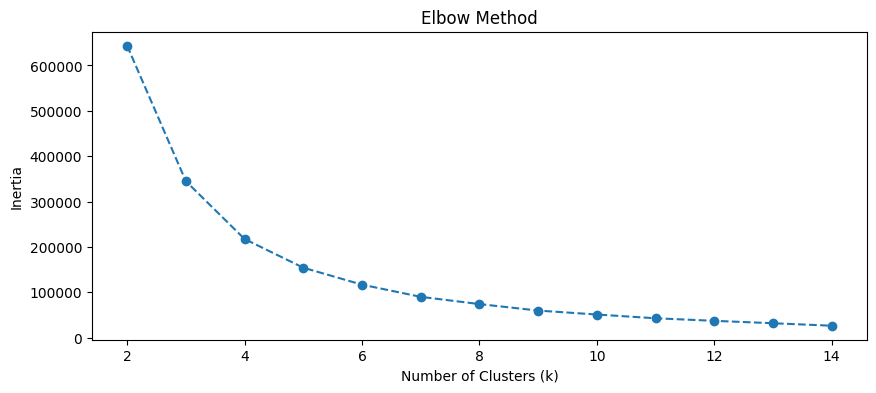

In [104]:
# for elbow method, want to find the point right before the inertia starts to decrease more slowly
# A clear "bend" in the curve indicates the point beyond which additional clusters do not provide substantial benefit.
plt.figure(figsize=(10, 4))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

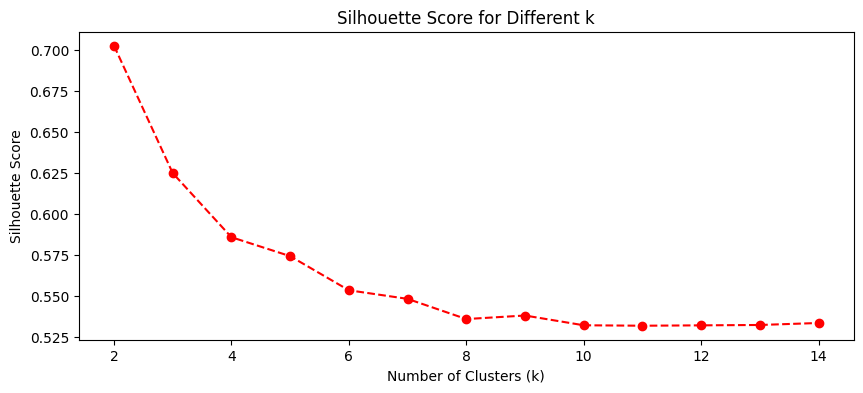

In [105]:
# for silhouette score, the higher the better -- maybe use 4/5 clusters

plt.figure(figsize=(10, 4))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

In [112]:
optimal_k = 4# Change this based on the elbow/silhouette method- both point to abt 5 

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_final)

df_final['cluster'] = cluster_labels  # Add cluster labels to original data, sorting into 5 clusters
print(df_final['cluster'].value_counts())

cluster
3    3443
1    2376
2    1038
0     344
Name: count, dtype: int64


In [114]:
cluster_summary = df_final.groupby("cluster").mean()
print(cluster_summary)

         priceEarningsRatio  priceToSalesRatio  enterpriseValueMultiple  \
cluster                                                                   
0                  0.261809          67.468646                 0.265117   
1                  0.255558          17.266905                 0.259208   
2                  0.258699          36.558955                 0.264189   
3                  0.249159           5.993734                 0.249770   

         priceToFreeCashFlowsRatio  
cluster                             
0                         0.068214  
1                         0.015919  
2                         0.039037  
3                        -0.029491  


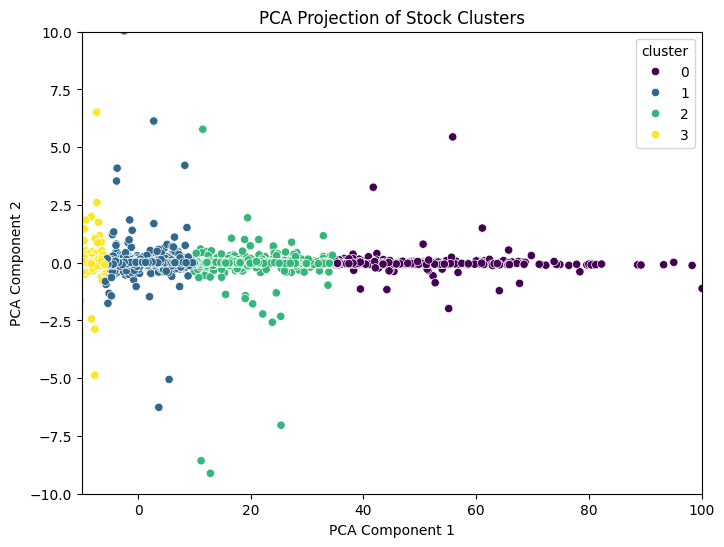

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_final.drop(columns=["cluster"]))  # Drop cluster column before PCA

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df_final["cluster"], palette="viridis")
plt.xlabel("PCA Component 1")
plt.xlim(-10, 100)
plt.ylabel("PCA Component 2")
plt.ylim(-10, 10) 
plt.title("PCA Projection of Stock Clusters")
plt.show()

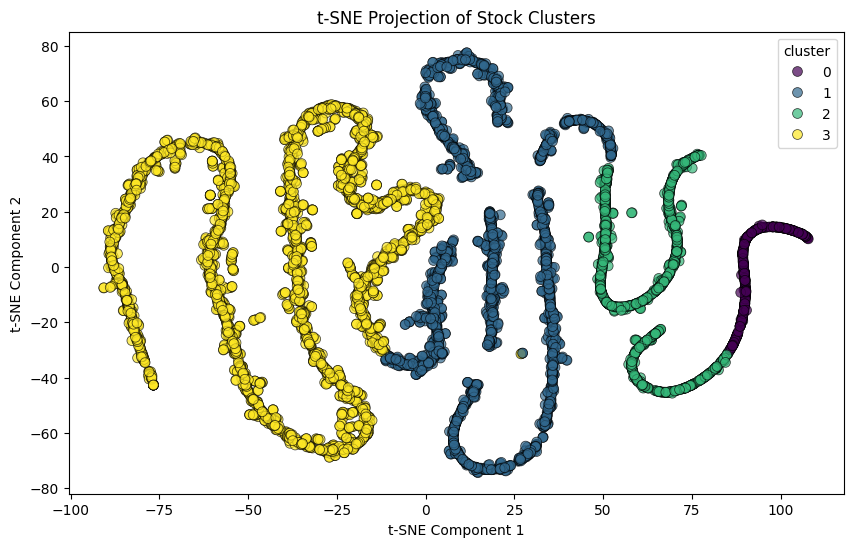

In [148]:
from sklearn.manifold import TSNE

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=100)
tsne_features = tsne.fit_transform(df_final.drop(columns=["cluster"]))

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=df_final["cluster"], 
                palette="viridis", s=50, alpha=0.7, edgecolor="black")

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Stock Clusters")
plt.show()

In [ ]:
# %run feature_engineer.ipynb